#🦷 Teeth Classification with Deep Learning

Welcome!
This notebook aims to build a deep learning model for classifying dental conditions into 7 categories using dental images. The pipeline includes:



1.   Preprocessing & data cleaning

1.   Exploratory data analysis (EDA)

1.   Data augmentation
2.   Model development using CNN


2.   Evaluation & metrics


2.   Deployment-ready Streamlit app












### Import Libraries

In [1]:
import os
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [2]:
!pip install gdown

In [3]:
!gdown --id 1WEySXMFz6v1OgPkLKJ8QIp3Lk-eyTObY -O teeth_dataset.zip

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1WEySXMFz6v1OgPkLKJ8QIp3Lk-eyTObY
From (redirected): https://drive.google.com/uc?id=1WEySXMFz6v1OgPkLKJ8QIp3Lk-eyTObY&confirm=t&uuid=e929b0d6-2cc0-485a-8b97-d58c8f237ea7
To: /content/teeth_dataset.zip
100% 49.1M/49.1M [00:00<00:00, 74.7MB/s]


In [4]:
!unzip teeth_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Teeth_Dataset/Validation/CoS/b_111_0_6094.jpg  
  inflating: Teeth_Dataset/Testing/CoS/b_150_0_2905.jpg  
  inflating: Teeth_Dataset/Testing/OT/ot_1241_0_1157.jpg  
  inflating: Teeth_Dataset/Validation/CoS/b_95 - Copy_0_6372.jpg  
  inflating: Teeth_Dataset/Testing/CaS/a_152_0_7749.jpg  
  inflating: Teeth_Dataset/Testing/CaS/a_126_0_9339.jpg  
  inflating: Teeth_Dataset/Testing/outputs/a_110_0_9820.jpg  
  inflating: Teeth_Dataset/Testing/outputs/a_141_0_7620.jpg  
  inflating: Teeth_Dataset/Validation/CoS/b_132_0_2266.jpg  
  inflating: Teeth_Dataset/Testing/outputs/a_99_0_9803.jpg  
  inflating: Teeth_Dataset/Testing/OT/ot_1223_0_6812.jpg  
  inflating: Teeth_Dataset/Testing/OT/ot_1223_0_6082.jpg  
  inflating: Teeth_Dataset/Testing/output/a_145_0_219.jpg  
  inflating: Teeth_Dataset/Testing/output/a_119_0_1965.jpg  
  inflating: Teeth_Dataset/Testing/CoS/b_112_0_1990.jpg  
  inflating: Teeth_Dataset/Testing/output/a_1

##📁 1. Dataset Setup
We start by organizing the dataset into training, validation, and test folders. We also remove any unwanted files or folders.

In [5]:
import os
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
main_dir = '/content/Teeth_Dataset'

train_dir = os.path.join(main_dir, 'Training')
val_dir = os.path.join(main_dir, 'Validation')
test_dir = os.path.join(main_dir, 'Testing')

print("Train folders:", os.listdir(train_dir))
print("Validation folders:", os.listdir(val_dir))
print("Test folders:", os.listdir(test_dir))

Train folders: ['Gum', 'MC', 'OT', 'CoS', 'OC', 'OLP', 'CaS']
Validation folders: ['Gum', 'MC', 'OT', 'CoS', 'OC', 'OLP', 'CaS']
Test folders: ['Gum', 'MC', 'OT', 'CoS', 'output_image.jpg', 'out', 'OC', 'outputs', 'OLP', 'CaS', 'output']


These extra items like:

*   output_image.jpg
*   output
*   out
*   outputs

are not valid class folders and will break the test data loader `(flow_from_directory)`, causing class mismatch or errors.

##🧹 2. Cleaning and Verifying Dataset Structure

Here, we:



*   Ensure only the correct class folders remain.

*   Remove unwanted images or files from the test set.




In [7]:
valid_classes = {'Gum', 'MC', 'OT', 'CoS', 'OC', 'OLP', 'CaS'}

# Path to test directory
for item in os.listdir(test_dir):
    item_path = os.path.join(test_dir, item)

    if os.path.isdir(item_path):
        if item not in valid_classes:
            print(f"Removing invalid folder: {item}")
            shutil.rmtree(item_path)
    else:
        print(f"Removing file: {item}")
        os.remove(item_path)


Removing file: output_image.jpg
Removing invalid folder: out
Removing invalid folder: outputs
Removing invalid folder: output


In [8]:
print("Train folders:", os.listdir(train_dir))
print("Validation folders:", os.listdir(val_dir))
print("Test folders:", os.listdir(test_dir))

Train folders: ['Gum', 'MC', 'OT', 'CoS', 'OC', 'OLP', 'CaS']
Validation folders: ['Gum', 'MC', 'OT', 'CoS', 'OC', 'OLP', 'CaS']
Test folders: ['Gum', 'MC', 'OT', 'CoS', 'OC', 'OLP', 'CaS']


##📊 3. Dataset Statistics

Let’s count how many images exist in each split (train, validation, test). This gives us a sense of dataset size and balance.

In [9]:
def count_images_in_directory(directory):
  """Counts the total number of files in a directory, including subdirectories."""
  total_images = 0
  for dirpath, dirnames, filenames in os.walk(directory):
    total_images += len(filenames)
  return total_images

train_image_count = count_images_in_directory(train_dir)
val_image_count = count_images_in_directory(val_dir)
test_image_count = count_images_in_directory(test_dir)

print(f"Total images in training set: {train_image_count}")
print(f"Total images in validation set: {val_image_count}")
print(f"Total images in test set: {test_image_count}")

Total images in training set: 3087
Total images in validation set: 1028
Total images in test set: 1028


##📈 4. Class Distribution Visualization

We visualize the number of images per class to check for imbalance.


*   This helps identify whether certain classes are under-represented.

*   Later, we may use techniques to address this.

In [10]:
def count_images_per_class(base_dir):
    counts = {}
    for class_name in sorted(os.listdir(base_dir)):
        class_path = os.path.join(base_dir, class_name)
        if os.path.isdir(class_path):
            counts[class_name] = len(os.listdir(class_path))
    return counts

train_counts = count_images_per_class(train_dir)
val_counts = count_images_per_class(val_dir)
test_counts = count_images_per_class(test_dir)

df = pd.DataFrame({
    'Train': train_counts,
    'Validation': val_counts,
    'Test': test_counts
}).T

display(df)


,CaS,CoS,Gum,MC,OC,OLP,OT
Train,480,450,360,540,324,540,393
Validation,160,149,120,180,108,180,131
Test,160,149,120,180,108,180,131


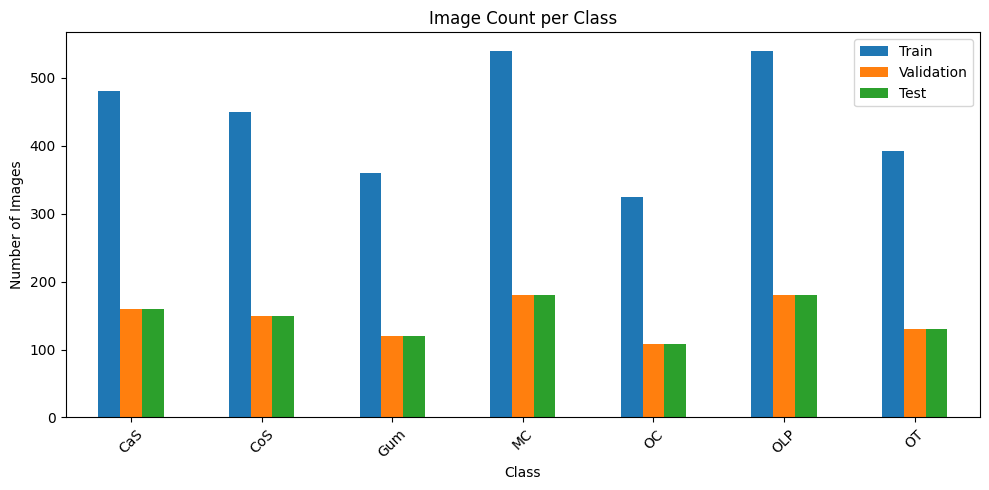

In [11]:
df.T.plot(kind='bar', figsize=(10, 5))
plt.title('Image Count per Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

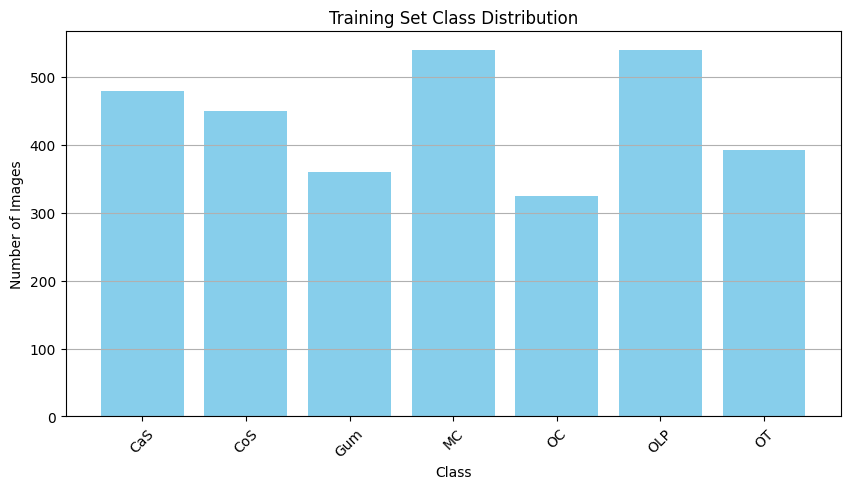

In [12]:
plt.figure(figsize=(10, 5))
plt.bar(train_counts.keys(), train_counts.values(), color='skyblue')
plt.title('Training Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

##⚙️ 5. Data Preprocessing & Augmentation
We apply preprocessing steps:


*   Resizing images to 256x256

*   Normalizing pixel values

*   Data augmentation: flipping, rotating, brightness adjustments, etc.

✅ **Important:** We use `image_dataset_from_directory()` which directly loads images into TensorFlow-ready datasets.

In [58]:
image_height = 256
image_width = 256
batch_size = 32

train_data_original = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(image_height, image_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True
)

val_data_original = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(image_height, image_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False
)

test_data_original = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(image_height, image_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False
)

Found 3087 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.


##🔍 6. Visualizing Before and After Augmentation

Let’s compare:


*   Original images

*   Augmented versions

This step ensures augmentation is beneficial and not distorting important features.

In [59]:
AUTOTUNE = tf.data.AUTOTUNE

# Get class names from one of the original datasets
class_names = train_data_original.class_names

train_data = train_data_original.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_data = val_data_original.cache().prefetch(buffer_size=AUTOTUNE)
test_data = test_data_original.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

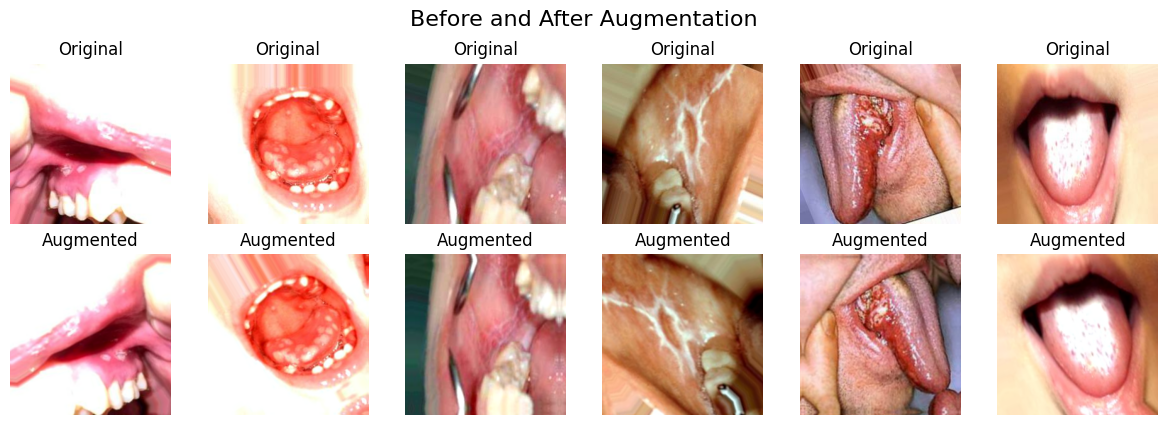

In [20]:
# Get a batch of images from the training dataset
for images, labels in train_data.take(1):
    sample_images = images[:6]  # Take first 6 images
    break

# Plot original images
plt.figure(figsize=(12, 4))
for i in range(6):
    plt.subplot(2, 6, i + 1)
    # No rescaling here, will be done in data_augmentation
    plt.imshow(sample_images[i].numpy().astype("uint8"))
    plt.title("Original")
    plt.axis("off")

# Apply augmentation
# data_augmentation now includes rescaling
augmented_images = data_augmentation(sample_images)

# Plot augmented images
for i in range(6):
    plt.subplot(2, 6, 6 + i + 1)
    # Rescaled and augmented images are now in the range [0, 1]
    # Convert to uint8 for plotting
    plt.imshow(augmented_images[i].numpy())
    plt.title("Augmented")
    plt.axis("off")

plt.tight_layout()
plt.suptitle("Before and After Augmentation", y=1.05, fontsize=16)
plt.show()

##🧠 7. Model Architecture
We build a Convolutional Neural Network (CNN) tailored for dental image classification.



*   Uses 3 convolution blocks


*   Batch normalization & dropout

*   Final dense layer with softmax for multi-class prediction

📌 **Tip:** You can replace this with a pre-trained model (e.g., ResNet50) for better performance later.

In [33]:
from tensorflow.keras import layers, models

input_shape = (256, 256, 3)

teeth_cnn = models.Sequential([
    layers.Rescaling(1./255, input_shape=input_shape),

    # Block 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    # Block 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    # Block 4
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    # Global pooling instead of flatten
    layers.GlobalAveragePooling2D(),

    # FC layers
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(7, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [34]:
teeth_cnn.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 424,135 (1.62 MB)

 Trainable params: 423,175 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

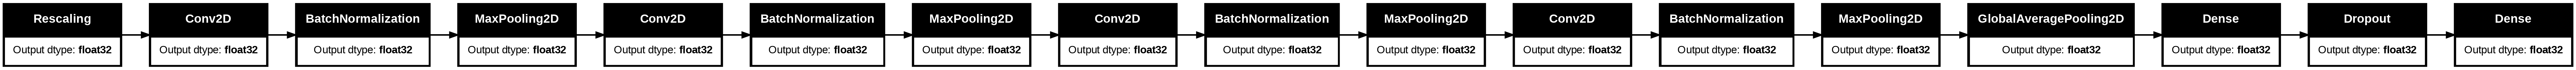

In [35]:
tf.keras.utils.plot_model(teeth_cnn, rankdir='LR', show_dtype=True)

##🧪 8. Compiling the Model

We compile the model with:



*   Loss function: `categorical_crossentropy` (multi-class)


*   Optimizer: `Adam`

*   Metrics: `accuracy`

In [36]:
teeth_cnn.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

##🏋️ 9. Model Training with Callbacks

We train the model with:


*   `EarlyStopping`: to prevent overfitting

*   `ReduceLROnPlateau`: to dynamically adjust learning rate

This ensures better generalization and faster convergence.

In [37]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True,
                               verbose=1)

# Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,
                              patience=3,
                              min_lr=1e-6,
                              verbose=1)

# Train the model
history = teeth_cnn.fit(train_data,
                        validation_data=val_data,
                        epochs=100,
                        callbacks=[early_stopping, reduce_lr])

Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 31s 196ms/step - accuracy: 0.2863 - loss: 1.9345 - val_accuracy: 0.1449 - val_loss: 3.4449 - learning_rate: 0.0010
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.3970 - loss: 1.5527 - val_accuracy: 0.1449 - val_loss: 5.1623 - learning_rate: 0.0010
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.4667 - loss: 1.3808 - val_accuracy: 0.1527 - val_loss: 4.5506 - learning_rate: 0.0010
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5155 - loss: 1.2788
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.5153 - loss: 1.2790 - val_accuracy: 0.1809 - val_loss: 4.0421 - learning_rate: 0.0010
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.5782 - loss: 1.1888 - val_accuracy: 0.3161 - val_loss: 2.6788 - learning_rate: 5.0000e-04
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.5943 - loss: 1

In [39]:
model_history = history.history

acc = model_history['accuracy']
val_acc = model_history['val_accuracy']
loss = model_history['loss']
val_loss = model_history['val_loss']

epochs = history.epoch

##📉 10. Training & Validation Curves

In [49]:
def plot_acc_loss(acc, val_acc, loss, val_loss, epochs):

  plt.figure(figsize=(12,4))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, acc, label='Training Accuracy')
  plt.plot(epochs, val_acc, label='Validation Accuracy')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc=0)

  plt.subplot(1, 2, 2)
  plt.plot(epochs, loss, label='Training Loss')
  plt.plot(epochs, val_loss, label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(loc=0)
  plt.show()

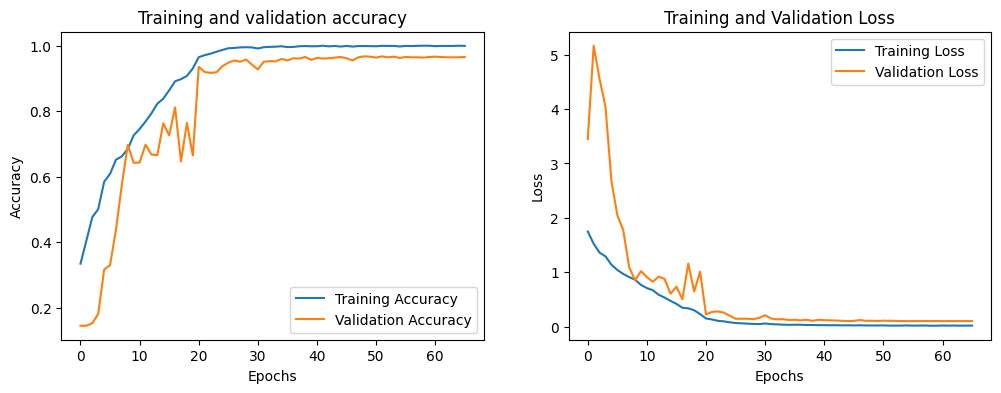

In [50]:
plot_acc_loss(acc, val_acc, loss, val_loss, epochs)

##✅ 11. Evaluation on Test Set

We evaluate the trained model on the test set and print:

*   Accuracy

*   Loss

*   Classification report

*   Confusion matrix


In [51]:
print("Evaluating model on the test dataset...")
test_loss, test_accuracy = teeth_cnn.evaluate(test_data)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

Evaluating model on the test dataset...
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.9723 - loss: 0.0779
Test Loss: 0.1094
Test Accuracy: 95.82%


In [64]:
from sklearn.metrics import classification_report, confusion_matrix

# Get predictions and true labels
y_pred = []
y_true = []

for images, labels in test_data:
    preds = teeth_cnn.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

y_pred = np.array(y_pred)
y_true = np.array(y_true)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━

In [65]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

         CaS       0.98      0.98      0.98       160
         CoS       0.98      0.99      0.99       149
         Gum       0.99      0.95      0.97       120
          MC       0.94      0.92      0.93       180
          OC       0.95      0.96      0.95       108
         OLP       0.93      0.96      0.94       180
          OT       0.95      0.95      0.95       131

    accuracy                           0.96      1028
   macro avg       0.96      0.96      0.96      1028
weighted avg       0.96      0.96      0.96      1028



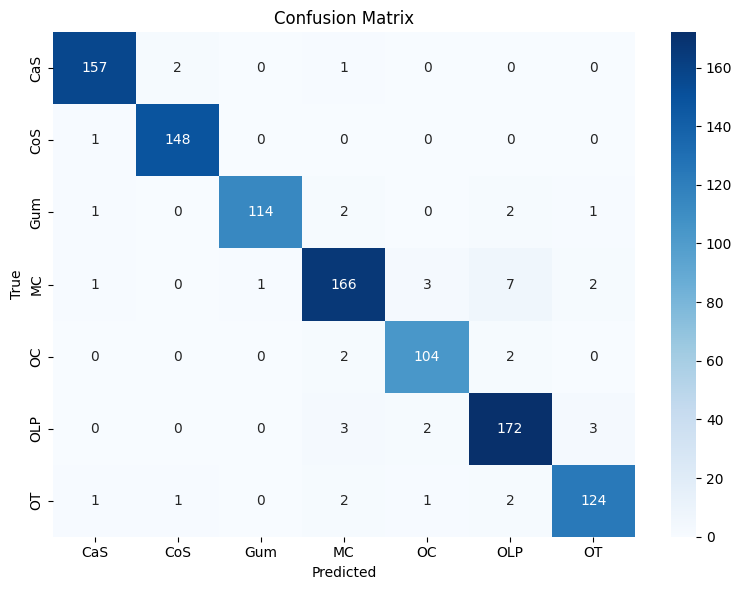

In [67]:
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


<Axes: >

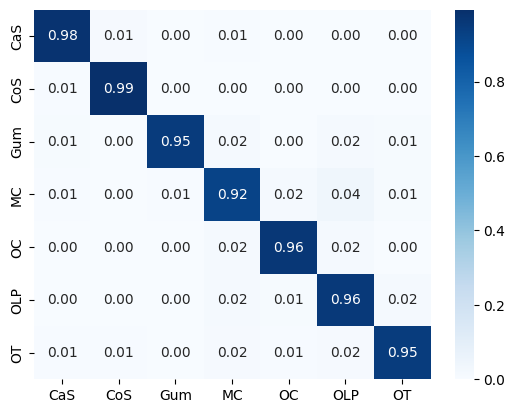

In [68]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

##🔎 12. Predictions Visualization

Show a few test images with:




*   Predicted label

*   True label



Great for a quick manual check of the model's performance.

In [55]:
def visualize_predictions(model, dataset, class_names, num_images=16):
    """
    Displays a grid of images from a dataset with their actual and predicted labels.
    """
    plt.figure(figsize=(15, 15))

    # Take one batch from the dataset
    for image_batch, label_batch in dataset.take(1):
        # Make predictions on the batch
        predictions = model.predict(image_batch)
        predicted_indices = np.argmax(predictions, axis=1)
        actual_indices = np.argmax(label_batch.numpy(), axis=1)

        # Calculate grid size
        grid_size = int(np.ceil(np.sqrt(num_images)))

        # Plot the images
        for i in range(num_images):
            ax = plt.subplot(grid_size, grid_size, i + 1)
            plt.imshow(image_batch[i].numpy().astype("uint8"))

            actual_label = class_names[actual_indices[i]]
            predicted_label = class_names[predicted_indices[i]]

            # Set the title color to green for correct predictions, red for incorrect
            color = "green" if actual_label == predicted_label else "red"

            # Get the predicted class name
            pred_class = class_names[predicted_indices[i]]
            # Get the confidence of the prediction
            conf = np.max(predictions[i])

            plt.title(f"Actual: {actual_label}\nPredicted: {pred_class} ({conf:.2f})", color=color, fontsize=12)
            plt.axis("off")

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


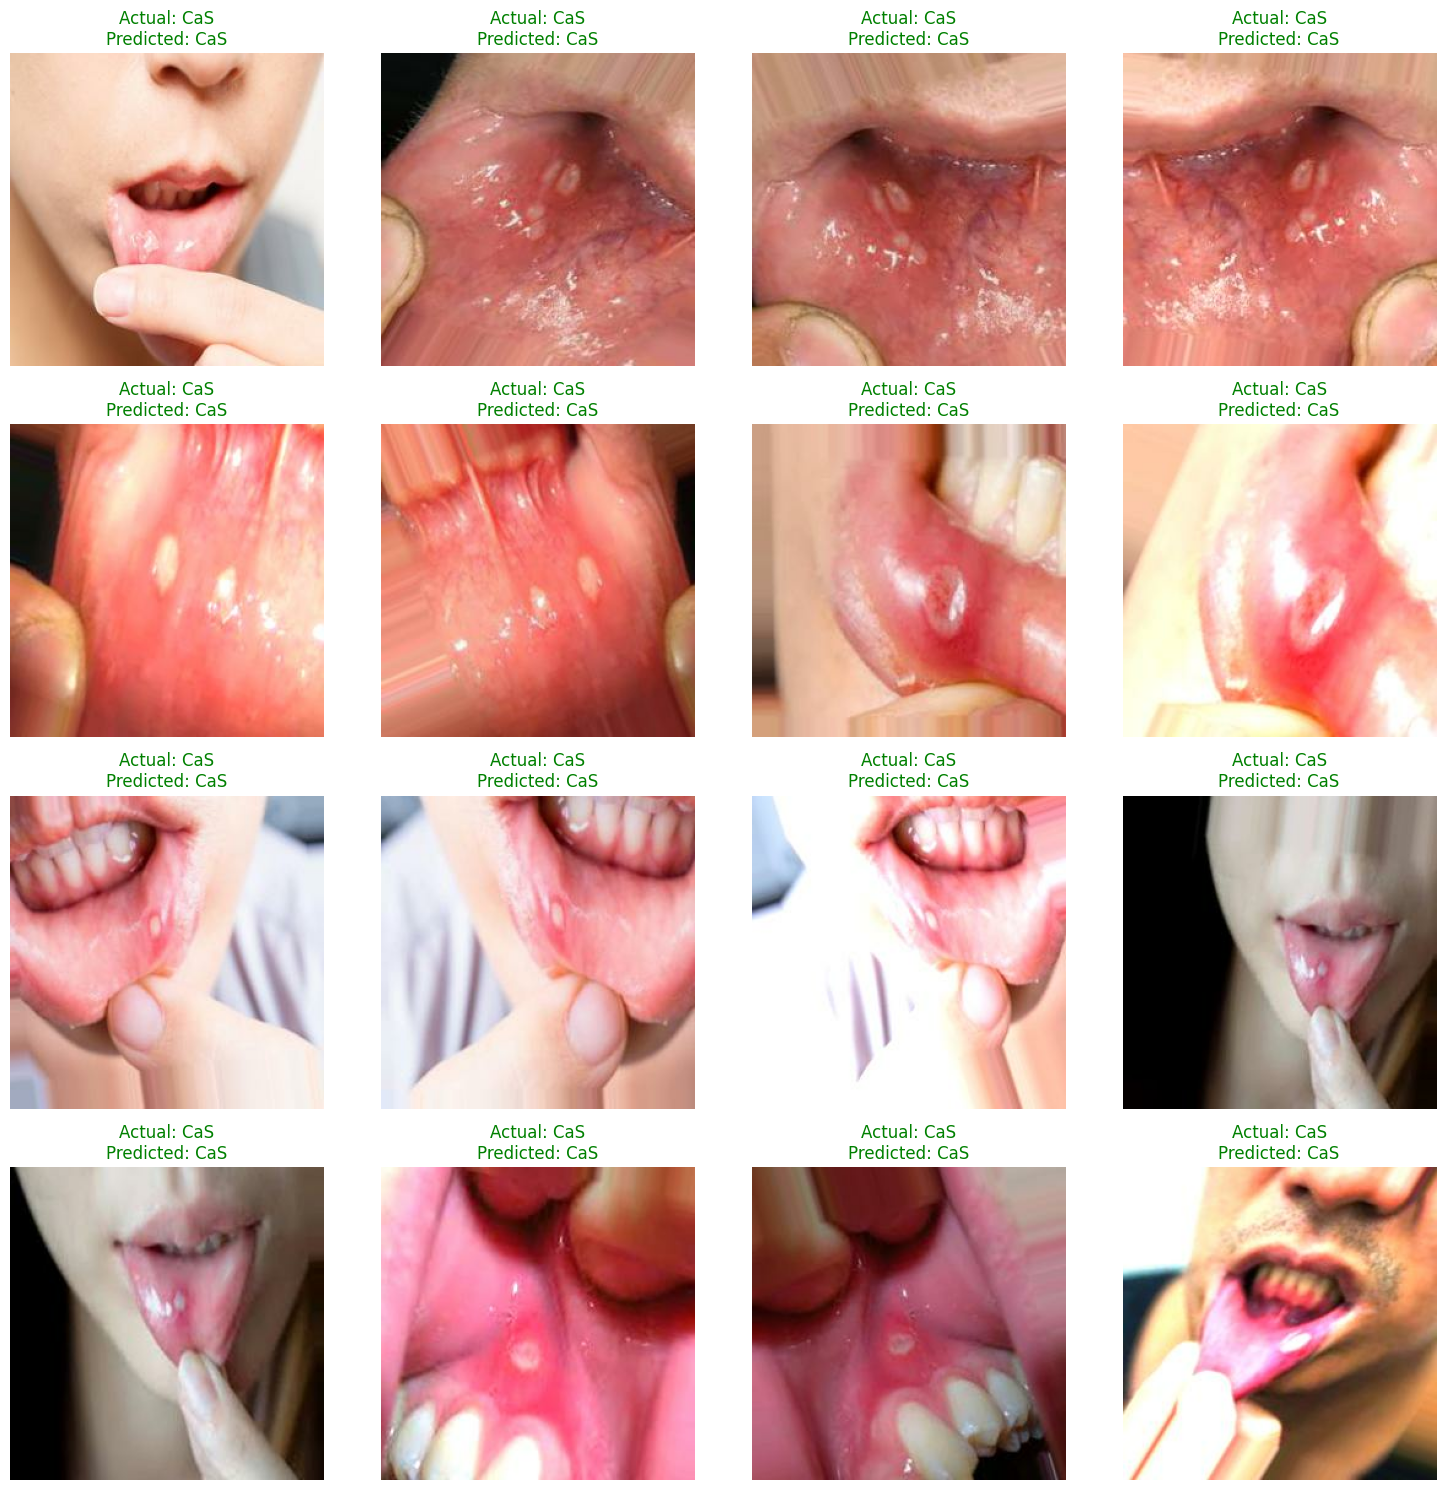

In [62]:
# Use the class_names obtained before caching and prefetching
visualize_predictions(teeth_cnn, test_data, class_names, num_images=16)

##🌐 13. Streamlit App Deployment

We build a user-friendly web app using Streamlit to allow:



*   Uploading dental images


*   Getting real-time predictions

*   Viewing probabilities per class

📦 Note: The model is saved as .keras and loaded in `streamlit_app.py`.

In [71]:
teeth_cnn.save("teeth_classifier_model.keras")